In [51]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# load data
offer_data = pd.read_csv('data/cleaned_offer_data.csv')

# Introduction

This notebook documents an analysis of the probability of completing various promotional offers based on Starbucks data. The notebook uses a cleaned data set on offers received by each user that was created in a separate notebook (starbucks_data_cleanup.ipynb).

The overall idea for the analysis is to use a machine learning algorithm to predict whether users complete (redeem) the offers from existing data on users and offers. We can then use models with sufficient predictive power to compare predicted probabilities of completing the offers for different segments of customers or for offers with different characteristics. In this analysis, we will mainly use logistic regression, as it usually performs well with respect to binary predictions, and it also allows us to examine the contribution of each predictor by looking at regression coefficients. We will also look at who is more likely to view offers using the same model setup.

At the end of the analysis, there is a discussion of the takeaways and possible improvements.

# Setting Up

First, we create several dummy variables for segments of the customer base based on age, income, gender, and when one became a member. As for age, standard age group ranges (0-20, 21-30, etc.) were used. Incomes in the data set were in the range from 30,000 to 120,000, so 20K brackets were used except for the first one (0-40). Membership duration was split into five bins: 0-3 months, 4-6 months, 7-12 months, 1-2 years, more than 2 years. We also add dummies for offer types: BOGO, discount, and informational (informational offers will not be used in this analysis as they cannot be 'completed').

In [52]:
# turn continuous variables to categorical
offer_data['age_group'] = pd.cut(
    offer_data.age, bins=[0, 20, 30, 40, 50, 60, 150],
    labels=['18-20', '21-30', '31-40', '41-50', '51-60', '61+'])
offer_data['income_group'] = pd.cut(
    offer_data.income, bins=[0, 40000, 60000, 80000, 100000, 120000],
    labels=['0-40K', '41-60K', '61-80K', '81-100K', '101-120K'])
offer_data['member_months_group'] = pd.cut(
    offer_data.member_months, bins=[0, 3, 6, 12, 24, 1000],
    labels=['0-3 months', '4-6 months', '7-12 months', 
            '1-2 years', '2+ years'])

# recode offer ids
offer_data['offer_id_alt'] = (offer_data.offer_type + ' ') + (
    offer_data.offer_reward.astype(str) + ' (') + (
        (offer_data.offer_duration/24).astype(int).astype(str) + ' days)')
        
# drop informational offers
offer_data = offer_data[offer_data.offer_type != 'informational']

# create dummies
offer_data = pd.concat([offer_data,
                            pd.get_dummies(offer_data['age_group'],
                                           prefix='Age'),
                            pd.get_dummies(offer_data['income_group'],
                                           prefix='Income'),
                            pd.get_dummies(offer_data['gender'],
                                           prefix='Gender'),
                            pd.get_dummies(offer_data['member_months_group'], 
                                           prefix='Member'),
                            pd.get_dummies(offer_data['offer_type'], 
                                           prefix='Type'),
                            pd.get_dummies(offer_data['offer_id_alt'], 
                                           prefix='Offer')],
                            axis=1)
                            

Next, we set up functions to split the data into train and test sets and to fit the models.

In this case, instead of using the standard train_test_split function, it is reasonable to split the data into train and test sets at the level of the user. For this purpose, we use a custom splitting function below.

In [53]:
def train_test_split_by_user(X, y):
    
    '''
    Create a train and test list of user ids, then split the data accordingly.
    
    Args:
        X: a data frame of predictors
        y: the target variable (pandas series)
    '''
    
    # create train and test sets of users
    train_ix, test_ix = next(gss.split(X, y, groups=X.user_id))
    
    # split into train and test
    X = X.drop(columns='user_id')
    X_train = X.iloc[train_ix]
    y_train = y.iloc[train_ix]
    X_test = X.iloc[test_ix]
    y_test = y.iloc[test_ix]
    
    return X_train, y_train, X_test, y_test

# initialize the command for splitting the data
gss = GroupShuffleSplit(n_splits=2, test_size=0.3, random_state=42)

The following function fits the models, outputs model evaluation, and, in case of logistic regression models, saves the regression coefficients for the subsequent interpretation.

In [54]:
def fit_test(model_pipeline, return_coefs=False):
    
    '''
    Fit the model, print out model evaluations on test data,
    return coefficients.
    
    Args:
        model_pipeline: a pipeline/a model object
    '''
    
    # Fit the model
    model_pipeline.fit(X_train, y_train)
    
    # Test the model
    y_pred = model_pipeline.predict(X_test)
    
    print('F1 score:')
    print(round(f1_score(y_test, y_pred), 3))
    print('Precision:')
    print(round(precision_score(y_test, y_pred), 3))
    print('Recall:')
    print(round(recall_score(y_test, y_pred), 3))
    
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model_pipeline, X_test, y_test, 
                                          normalize='all')
    
    if return_coefs:
        coef_list = [recode_coefs(c) for c in X_train.columns.tolist()]
        coefs = pd.DataFrame({'Coefficient': model_pipeline.named_steps[
                              'logit'].coef_.flatten()},
                              index=coef_list)
        return coefs
    
    else:
        return None

# recode variable names
def recode_coefs(coef):
    
    '''
    Relabels variable names for plots.
    '''
    coef = coef.replace('Offer_', '')
    coef = coef.replace('_', ' ')
    coef = coef.replace('bogo', 'BOGO')
    coef = coef.replace('discount', 'Discount')
    coef = coef.replace('any', 'Any')
    coef = coef.replace('same', 'Same')
    coef = coef.replace('saw', 'Saw')
    
    return(coef)

For this analysis, we set up two model pipelines, one using logistic regression, and another using gradient boosting. In both cases, data are normalized using a MinMaxScaler from sklearn, which rescales each variable to take values from 0 to 1. This is more appropriate in this case compared to standard centering and scaling because many of the variables are dummies.

In [55]:
# instantiate model pipelines
pipeline_logit = Pipeline([
    ('scaler', MinMaxScaler()),
    ('logit', LogisticRegression())
])

pipeline_boost = Pipeline([
    ('scaler', MinMaxScaler()),
    ('boost', GradientBoostingClassifier(random_state=42))
])

In the analysis below, we will use the following set of predictors:
- Dummies for promo campaigns (offers). While the data contain several characteristics for each offer, such as its type, reward, duration, and required spending, there are just 8 offers in this analysis (after dropping 2 informational ones), and including all these specific characteristics will be essentially the same as including just the offer ids, as the set of these features allows to identify each offer precisely (see the list of offers below). It would thus be easier to interpret the results if we include just the dummies for each offer. The dummy 'bogo 5 (5 days)' is omitted and serves as the reference category.
- The count of previously completed offers by the same user (one variable counts offers with the same id, the other variable counts all previously completed offers). This allows us to capture whether one tends to spend more or to seek offers more actively.
- Age groups. The group 'Age 18-20' serves as a reference category.
- Income groups. The group '0-40K' serves as a reference category.
- Gender. 'Male' is the reference category.
- How long one has been a member. '0-3 months' is a reference category.

In [56]:
print('Offers in the analysis (the number after offer type is reward value in dollars):')
print(offer_data.sort_values('offer_id_alt').offer_id_alt.unique().tolist())

x_vars = ['Offer_bogo 10 (5 days)', 'Offer_bogo 10 (7 days)', 
          'Offer_bogo 5 (7 days)',
          'Offer_discount 2 (7 days)',  'Offer_discount 2 (10 days)',
          'Offer_discount 3 (7 days)', 'Offer_discount 5 (10 days)', 
          'same_offer_completed_before', 'any_offer_completed_before',
          'Age_21-30', 'Age_31-40', 'Age_41-50', 'Age_51-60', 'Age_61+',
          'Income_41-60K', 'Income_61-80K', 'Income_81-100K', 
          'Income_101-120K', 
          'Gender_Female', 'Gender_Other', 
          'Member_4-6 months', 'Member_7-12 months',
          'Member_1-2 years', 'Member_2+ years']

Offers in the analysis (the number after offer type is reward value in dollars):
['bogo 10 (5 days)', 'bogo 10 (7 days)', 'bogo 5 (5 days)', 'bogo 5 (7 days)', 'discount 2 (10 days)', 'discount 2 (7 days)', 'discount 3 (7 days)', 'discount 5 (10 days)']


Next, we create a matrix of predictors X and the outcome variable, and then we split the data into the training and test sets.

In [57]:
# X and y
offer_data_X = offer_data[['user_id'] + x_vars]
offer_data_y = offer_data['completed']

# train and test
X_train, y_train, X_test, y_test = train_test_split_by_user(offer_data_X,
                                                            offer_data_y)

# Analysis

## Finding the Best-Performing Model

### Logistic Regression

The logistic regression implementation in sklearn by default includes a regularization penalty, but the strength of regularization could be tuned via the parameter called C. First, we use grid search with cross-validation to find the optimal value of C.



F1 score:
0.799
Precision:
0.774
Recall:
0.826
Confusion matrix:
[[3557 2401]
 [1733 8221]]


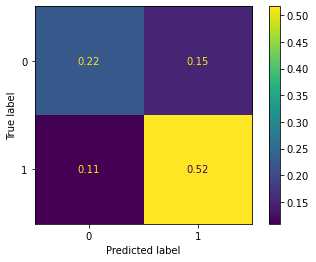

In [58]:
# grid search for optimal model parameters
parameters_logit = {
        'logit__C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000]
    }
logit_cv = GridSearchCV(pipeline_logit, param_grid=parameters_logit)
fit_test(logit_cv)

The best model has an F1 score of 0.8. F1 score is a single metric that takes into account both model precision and recall, where precision shows what percent of the offers that the model predicted to be completed were actually completed, and recall shows what percent of all completed offers the model was able to predict as completed. It is important to consider both precision and recall because we want our models to minimize both false positives and false negatives, and F1 score is a convenient combination of these metrics. However, in addition, this code also prints out precision and recall. 

Looking at precision and recall is also important in our specific case because there is some class imbalance in the data: offers were completed in about 63 percent of cases (see the confusion matrix for the total number of true positives). This might bias the model in favor of positive results. We can see that there is some such bias indeed, both from the confusion matrix where there are more false positives than false negatives, and from the fact that model precision is somewhat lower than recall. But this bias is not too severe, given the relatively small difference between two metrics.

As for the optimal value of C, it is 10, as shown below, so this is what we will use going forward.

In [59]:
print('Optimal parameter: ' + str(logit_cv.best_params_))

Optimal parameter: {'logit__C': 10}


### Gradient Boosting

As an alternative, we'll consider another classifier, gradient boosting, also implemented in sklearn. This is an ensemble tree-based model. In this case, we'll tune three parameters: learning rate (the contribution of each tree to final predictions), the number of estimators (boosting stages), and max depth (the number of nodes in each tree).

F1 score:
0.803
Precision:
0.783
Recall:
0.824
Confusion matrix:
[[3682 2276]
 [1750 8204]]


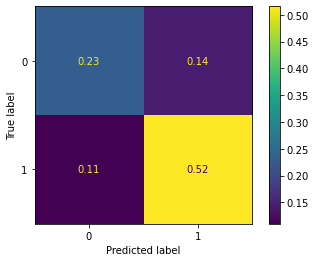

In [60]:
# grid search for optimal parameters
parameters_boost = {
        'boost__max_depth': [1, 2, 3, 4, 5],
        'boost__n_estimators': [10, 50, 100, 200],
        'boost__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    }
boost_cv = GridSearchCV(pipeline_boost, param_grid=parameters_boost)
fit_test(boost_cv)


Here are the optimal parameters for this model. As the results above show, the F1 score of the gradient boosting classifier is almost the same as in the logistic regression case above (slightly lower recall and slightly higher precision). Given that the logistic regression model allows for easier interpretation of results based on regression coefficients, we will use it for the remaining analysis.

In [61]:
print(boost_cv.best_params_)

{'boost__learning_rate': 0.2, 'boost__max_depth': 3, 'boost__n_estimators': 100}


## Predicting Offer Completion

Now, let's examine the regression coefficients using the tuned logistic model. It is not straightforward to derive the exact numeric differences in the probability of completing the offer between customer segments or offers because the predictor variables were rescaled. Rather, the goal of this discussion is to provide some intuitive understanding about when this probability is higher. A positive coefficient means that the probability of completing the offer is higher for a particular category of users or offers compared to the reference category. The larger the coefficient, the more likely is the offer to be completed. And vice versa, negative coefficients mean lower probability of completing offers.

F1 score:
0.799
Precision:
0.774
Recall:
0.826
Confusion matrix:
[[3557 2401]
 [1733 8221]]


<AxesSubplot:title={'center':'What predicts offer completion?'}, ylabel='Logistic regression coefficient'>

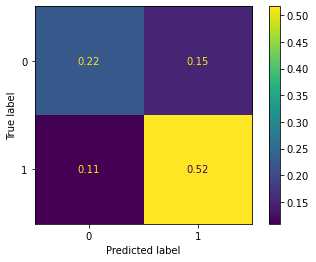

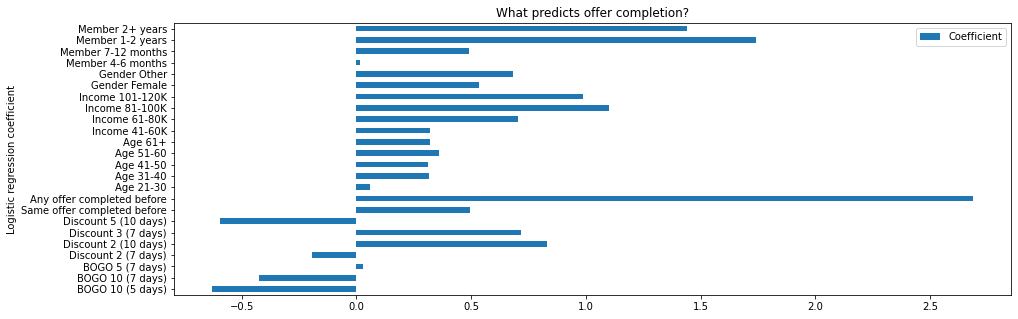

In [62]:
# predicting completion
completion_coefs = fit_test(logit_cv.best_estimator_, return_coefs=True)

completion_coefs.plot.barh(figsize=[15,5], 
                           ylabel='Logistic regression coefficient', 
                           title='What predicts offer completion?')

It's worth keeping in mind that when we have several dummies, e.g., for the duration of membership, the coefficients on these dummies reflect how the corresponding categories related to the omitted category. In case of membership, the reference category is those who have been members for 0-3 months. Compared to them, all other groups of members were *more* likely to complete offers. But members with a longer track record were in general more likely to redeem offers, even compared to those who were members for 4-6 months or 7-12 months. 

Similarly, compared to males (omitted category), female customers and those who specified their gender as 'other' were more likely to complete offers, as were customers who earned more compared to those with lower income. As for age, customers over 30 were more likely to complete offers than customers between 18 and 30 years old.

These differences are sizeable. On average, conditional on all the other variables, the model predicts that male customers in the test set would complete their offers in 55 percent of cases, but female customers would complete the offers in 71 percent of cases. Similarly, predicted completion probability is 49 percent for younger customers (21--30) but 66 percent for older customers (51--60); see the code chunk below.

In [63]:
# predictions: who will complete the offer
# females and males
pred_f = logit_cv.best_estimator_.predict_proba(
    X_test[X_test.Gender_Female == 1])
pred_m = logit_cv.best_estimator_.predict_proba(
    X_test[(X_test.Gender_Female == 0) & (X_test.Gender_Other == 0)])

print('In the test set, ' + str(round(100*pred_f[:, 1].mean(), 1)) + ' percent of female customers and ' + str(round(100*pred_m[:, 1].mean(), 1)) + ' percent of male customers are predicted to complete offers')

# customers in the 21-30 age group and in the 51-60 age group
pred_21_30 = logit_cv.best_estimator_.predict_proba(
    X_test[X_test['Age_21-30'] == 1])
pred_51_60 = logit_cv.best_estimator_.predict_proba(
    X_test[X_test['Age_51-60'] == 1])
pred_21_30[:, 1].mean()
pred_51_60[:, 1].mean()

print('Predicted probability of completing the offer is ' + str(round(100*pred_21_30[:, 1].mean(), 1)) + ' percent for customers in 21-30 age group, but it is ' + str(round(100*pred_51_60[:, 1].mean(), 1)) + ' percent among customers between 51 and 60 years old')

In the test set, 71.1 percent of female customers and 54.6 percent of male customers are predicted to complete offers
Predicted probability of completing the offer is 48.7 percent for customers in 21-30 age group, but it is 65.6 percent among customers between 51 and 60 years old


Further, customers who have previously completed either the same offer or any other offer were also more likely to redeem offers. As noted before, either these customers generally make orders more frequently, or these are individuals who tend to look out for promo offers and make use of them.

As for specific offers, there was no clear pattern. While two discount offers turned out to be more effective than the rest, two other discount offers were less popular---about the same as a couple of BOGO offers. It does not seem like there is a pattern with respect to reward size or offer duration. The only possible conclusion is that discount offers may be somewhat more attractive than BOGO offers, which makes sense.

## Accounting for the Knowledge of the Offer

A flaw of the model described above is that it considered all customers at once without distinguishing between those who did and did not see the offers in question. But some people would complete offers even without knowing about them just because they spend some amount regularly. What we want to know is whether an offer makes it more likely that people would spend more. So one possibility is to consider customers who did not see the offer to be spending as they would usually spend, whereas customers who saw the offer would be spending under the influence of this offer. (Ideally, of course, we would use a different study setup, on which see below.)

There are different ways in which we can tackle this issue. First, we can simply add a dummy that indicates whether one saw the offer or not to the regression and check the coefficient. To do this, we add a new variable *saw_offer* that takes the value of 1 if the customer viewed the offer and then completed it or viewed the offer and did not complete it; the variable takes the value of 0 if the customer viewed the offer after completing it or did not view it at all.

F1 score:
0.799
Precision:
0.774
Recall:
0.827
Confusion matrix:
[[3547 2411]
 [1720 8234]]


<AxesSubplot:title={'center':'What predicts offer completion?'}, ylabel='Logistic regression coefficient'>

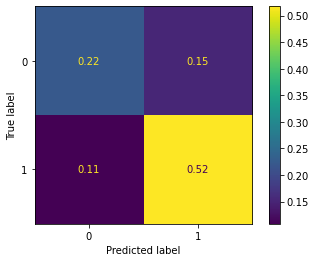

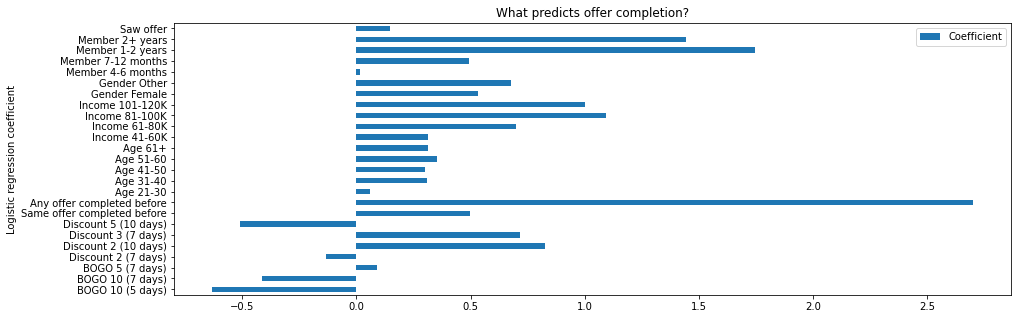

In [64]:
offer_data['saw_offer'] = (
    (offer_data.viewed == 1) &
    (offer_data.viewed_before != 0)).astype(int)

offer_data_X = offer_data[['user_id'] + x_vars + ['saw_offer']]
offer_data_y = offer_data['completed']

# train and test
X_train, y_train, X_test, y_test = train_test_split_by_user(offer_data_X,
                                                            offer_data_y)

# fit 
completion_coefs_saw = fit_test(logit_cv.best_estimator_, return_coefs=True)

completion_coefs_saw.plot.barh(figsize=[15,5], 
                               ylabel='Logistic regression coefficient', 
                               title='What predicts offer completion?')

The coefficient on whether one saw the offer is somewhat positive, but its magnitude is small compared to the differences between various other customer segments. Thus, we might think that those who actually saw promo offers were not *much* more likely to complete them.

Another way to look at this is to complete the average probability of completing the offer for those who saw them and those who did not see them. Again, not a dramatic difference, although it is probably still meaningful given how large Starbucks is; a few percentage points change in the probability of completing an offer may mean tens of millions of dollars a year in additional customer spending.

In [65]:
print('Percent of completed offers among customers who viewed offers: ' + str(round(offer_data.groupby('saw_offer').completed.mean()[1]*100, 1)) + '%')
print('Percent of completed offers among customers who did not view offers: ' + str(round(offer_data.groupby('saw_offer').completed.mean()[0]*100, 1)) + '%')

Percent of completed offers among customers who viewed offers: 62.4%
Percent of completed offers among customers who did not view offers: 58.1%


One other possibility, however, is that learning about an offer did not have much impact on average, but it had a larger impact on certain customer segments or for certain offers. In other words, it would be worth knowing whether the probability of completing the offer depends on viewing it more for some customer segments and less for others (same for specific offers). 

There are different ways to set up this analysis. To make it more straightforward, I apply the same model as above separately to (a) those who saw offers before they had a chance to complete them, and (b) those who did not see offers at all or saw them only after completing them. The code below runs the model twice for these two subsamples and plots the coefficients from two models.

F1 score:
0.801
Precision:
0.772
Recall:
0.832
Confusion matrix:
[[2399 1673]
 [1143 5651]]
F1 score:
0.781
Precision:
0.76
Recall:
0.803
Confusion matrix:
[[1432  729]
 [ 567 2310]]


<AxesSubplot:title={'center':'What predicts offer completion?'}, ylabel='Logistic regression coefficient'>

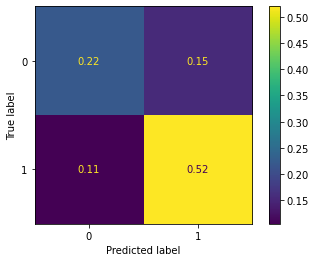

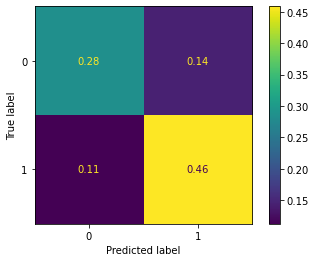

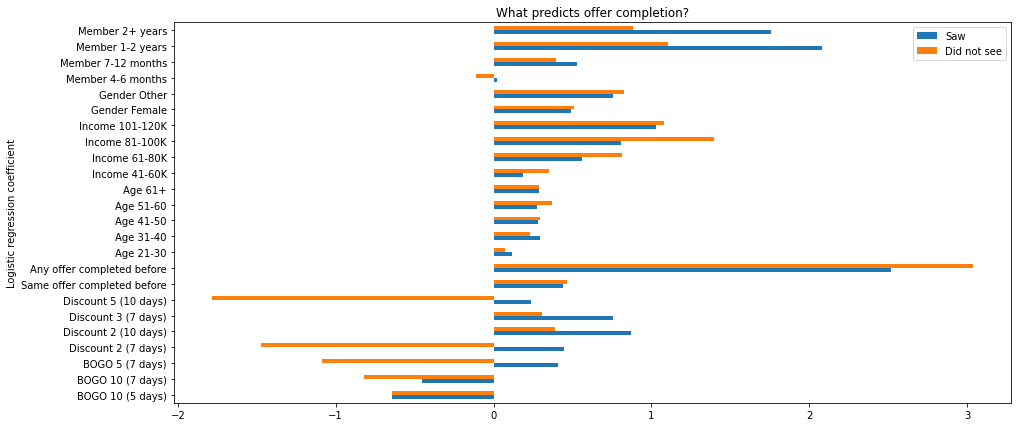

In [66]:
# X and y
offer_data_s_X = offer_data[
    offer_data.saw_offer == 1][['user_id'] + x_vars]
offer_data_ds_X = offer_data[
    offer_data.saw_offer == 0][['user_id'] + x_vars]
offer_data_s_y = offer_data[
    offer_data.saw_offer == 1]['completed']
offer_data_ds_y = offer_data[
    offer_data.saw_offer == 0]['completed']

# train and test 1
X_train, y_train, X_test, y_test = train_test_split_by_user(
    offer_data_s_X, offer_data_s_y)

# fit 1
completion_coefs_s = fit_test(logit_cv.best_estimator_, return_coefs=True)

# train and test 2
X_train, y_train, X_test, y_test = train_test_split_by_user(
    offer_data_ds_X, offer_data_ds_y)

# fit 2
completion_coefs_ds = fit_test(logit_cv.best_estimator_, return_coefs=True)

# combine coefficients into one data frame
completion_coefs_sds = pd.concat([completion_coefs_s, 
                                 completion_coefs_ds],
                                 axis=1)
completion_coefs_sds.columns = ['Saw', 'Did not see']

# plot
completion_coefs_sds.plot.barh(figsize=[15,7], 
                               ylabel='Logistic regression coefficient', 
                               title='What predicts offer completion?')

From the plot, we can see that in many cases, there was not much difference in terms of the probability of completing offers in specific customer segments depending on whether customers viewed the offer or not. For example, the coefficients for females or customers in different age groups were about the same in the group that viewed offers and in the group that did not view them. Here are a few cases that stood out and would be worth highlighting:
- Those who have been members for more than 1 year were substantially more likely to complete offers when they saw promos than when they did not.
- In all income groups above 40K, but especially so in groups between 60K and 100K, customers who saw offers were *less* likely to complete these offers than when they did not see the offers. Not quite clear why this pattern might emerge.
- With respect to specific offers, all discounts were clearly more likely to be redeemed when they were seen, whereas with BOGOs, this was not always the case. This may suggest, again, that discounts were generally more attractive to customers than BOGO offers.

Except for these cases, however, the differences in completion probabilities between those who viewed offers and those who did not were not dramatic. This may suggest two possibilities: (1) promo offers in general were not extremely motivating, possibly because many customers were spending enough money anyway; (2) viewing the offer does not correctly reflect actual awareness of the offer, as customers could have learned about these offers in other ways. We will return to this issue at the end. 

## Predicting The Probability of Viewing Offers

If we want to maximize the effectiveness of promo offers, not only we need to know who is more likely to use them when aware of them, but we also need to know who is more likely to see these offers. For this reason, it is worth conducting an analogous analysis of the probability of *viewing* the offers. The next code chunk does this and plots the coefficients.

F1 score:
0.885
Precision:
0.873
Recall:
0.896
Confusion matrix:
[[ 2197  1581]
 [ 1259 10875]]


<AxesSubplot:title={'center':'What predicts the viewing of offers?'}, ylabel='Logistic regression coefficient'>

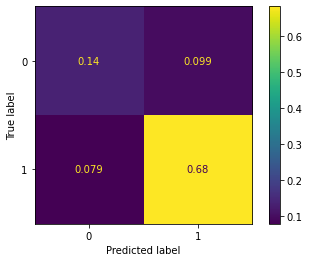

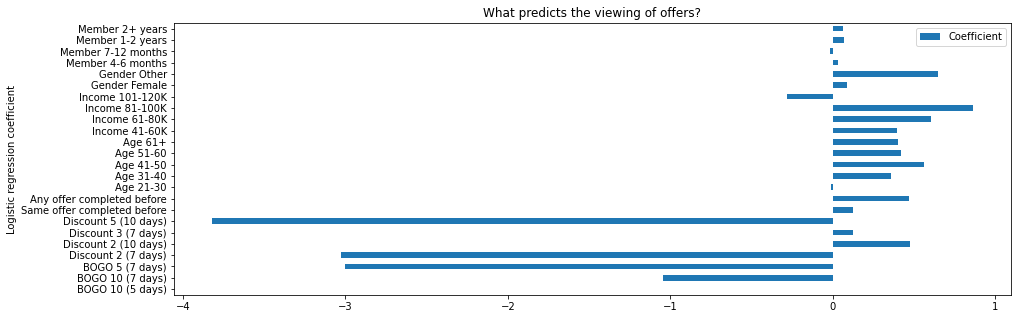

In [67]:
# X and y
data_viewing_X = offer_data[['user_id'] + x_vars]
data_viewing_y = offer_data['viewed']

# train and test
X_train, y_train, X_test, y_test = train_test_split_by_user(data_viewing_X,
                                                            data_viewing_y)

# fit 
viewing_coefs = fit_test(logit_cv.best_estimator_, return_coefs=True)

# plot
viewing_coefs.plot.barh(figsize=[15,5], 
                        ylabel='Logistic regression coefficient', 
                        title='What predicts the viewing of offers?')


Several things to highlight on this plot:
- Not much difference in the probability of viewing depending on membership duration.
- Not much difference between males and females.
- Customers with incomes between 40K and 100K were more likely to view offers (especially those in the 60K-100K range) than both the wealthiest (over 100K) and the poorest (less than 40K) customers. The wealthiest may not care for promo offers much, and the poorest may not always be able to afford completing them.
- Customers over 30 were more likely to view the offers than younger customers.
- Those who completed offers before were more likely to view new offers.
- Some offers were much less likely to be viewed than others, but there is no clear pattern in terms of, say, discounts vs BOGO offers or the amount of the reward.

This might suggest that some additional efforts might be needed to make the offers more visible to certain customer segments (younger or poorer customers), but it is important first to investigate why these customers pay less attention to promotional activities. It could be, for example, that they believe the offers are generally not worth their time, and then changing the structure of the offers (requirements or benefits) might help.

It is also worth noting that the predictive capacity of the model with respect to viewing was higher than with respect to offer completion. F1 score was about 0.89 (versus 0.8 in the model of offer completion). The confusion matrix shows fewer both false positives and false negatives. This suggests that sociodemographic and offer characteristics are fairly informative in terms of who is more likely to view the offer. That highlights again that viewing offers in this data set is not random---rather, it's to a large extent determined by the characteristics of customers and offers.

# Discussion

Some segments of the customer base---e.g., females and older customers---complete offers more often than others, but this is not necessarily a consequence of learning about these offers. Given existing data, it is possible that these customers simply spend more in general, and thus they often complete offers automatically, even without knowing that they were offered these deals.

At the same time, there is a group of customers that is more likely to view and complete offers---even after we control for their demographic characteristics. It is important to understand what else distinguishes that group, and whether this is a group that simply spends more in general, or they are specifically interested in promotions and seek such offers.

Here is a brief breakdown of main demographic features of users who completed 4 or more offers during the test vs those who completed 3 or less offers. Customers with more completed offers are slightly older, they are more likely to be female, they have higher income, and they have been members for somewhat longer. However, it would be important to learn what else is different about them: their customer preferences, spending patterns, etc.

In [68]:
# checking the features of those who complete more offers
offer_data['max_offers_completed'] = offer_data.groupby(
    ['user_id'])['any_offer_completed_before'].transform('max')

# a data frame with one row per user
users_offers = offer_data[['user_id', 
                           'max_offers_completed',
                           'age', 'Gender_Female', 'income',
                           'member_months'
                           ]].drop_duplicates()

print('The number of users by the maximum completed offers:')
print(users_offers['max_offers_completed'].value_counts())

# dummy for those who completed 4 or more offers
users_offers['4_offers_completed'] = (
    users_offers.max_offers_completed >= 4).astype(int)

print('Mean demographics for those who completed 4+ offers vs less:')
print(users_offers.drop(columns='max_offers_completed').groupby(['4_offers_completed']).mean())

The number of users by the maximum completed offers:
0    3861
2    3558
1    3555
3    2451
4    1109
5     230
Name: max_offers_completed, dtype: int64
Mean demographics for those who completed 4+ offers vs less:
                          age  Gender_Female        income  member_months
4_offers_completed                                                       
0                   54.268603       0.402905  64856.610801      17.586965
1                   55.696789       0.518297  71020.911128      20.562360


There are also a couple of important limitations in the current data. One of them is that not everyone saw the offers they were sent, and that complicates the analysis in terms of establishing whether offers actually prompt customers to place more orders. We have tried to overcome this issue by comparing customers who viewed offers and those who did not, but this is still not enough to correctly estimate the effect of getting an offer. It could be, for example, that some customers are more likely to spend more, but they are also more likely to be on their app more and thus view offers more frequently, but viewing does not substantially change the probability of completing the offer because they would spend that money anyway. 

It is also not clear whether viewing correctly represents awareness of offers. If "viewed" means "viewed in the app", customers may have learned about the same offer via email or social media, and so "viewed" in the current data does not tell us much about whether one actually knows about the offer. This might be why there was not much difference in offer completion between those customers who "viewed" offers or did not view them. However, even if "viewed" captures some other channels like email, we still don't know whether customers could have learned about the offer in some other way. E.g., they could have seen a push notification about the offer on their phone, but they didn't actually tap on it, and the app didn't register their awareness. In sum, we should know a lot more about how the offers were sent and how customers could have learned about them. 

One idea for a future analysis of the data would be to establish which users were "under the influence" of any particular offers at any given moment in time and which users were not (that is, they were not assigned to receive any offers). In that case, we could compare how much users spend when there is an offer in effect versus when there is no offer. However, with the current data set, there are still limitations on how much we could learn from such an analysis. One problem with that is that customers may have received multiple offers at the same time, and it would be impossible to establish the effect of any particular promotion. Another problem is the issue of viewing/not viewing discussed above, which would complicate things a lot.

A better way to address these problems would be to set up a proper randomized controlled experiment. In such a study, some customers would be randomly assigned to receive one of several offers, and there would also be a control group that does not receive any offers. We should also ensure that all groups are similar in terms of the offers that they previously received (e.g., only include those customers who have not received any offers in the last month). We should also spread information about the offer through only one particular channel that we're interested in (app, email, etc.) to limit spillover effects. A setup like that would allow us to estimate the effect of each individual offer on customer spending in comparison to the control group to which no offers are sent. It would not address the issue that some people would simply not view the offer, but a randomized controlled trial will at least ensure that customers are not under the influence of some other offer.

# Conclusion and Takeaways

This analysis has shown that we can predict offer completion for different segments of customers based on their demographic and other characteristics, although the predictions were far from perfect (accuracy was around 75 percent, based on the confusion matrices shown above). We can use the insights from these models to understand what customer segments are more responsive to offers, and in which segments, it is economically feasible to implement new promotions.

Learning more about the process behind these promotions (e.g., how the users may have got aware of the offers) would help to use the data more effectively and get additional insights. However, some issues may not be solved without additional data collection.

Here are the main takeaways from the analysis:
- The company might want to reassess which customer segments should receive more offers in the future. E.g., is it profitable to continue sending offers to customers who regularly spend certain amounts either way (e.g., older customers, females)? Is it worth adding more targeted efforts to reach customers who are less likely to complete offers (e.g., males, younger customers)---or redesigning promotions for these customers?
- Overall, more than 60 percent of customers completed offers they received, and even among those who did not view these offers, completion rate was much higher than 50 percent. It might be worth reflecting on whether these offers were too "easy" to complete (unless that was the goal).
- It would be useful to learn more about those customers who complete more offers: what do they like, how do they use the app, etc.?
- To estimate the precise economic effect of each particular promotion, it is worth setting up a proper experiment.